# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook's objective is to meet the requirements in the [rubric](https://review.udacity.com/#!/rubrics/481/view).

## Load Data

Load the traffic sign data, which came pre-packaged in Pickle files


In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mat
import pickle
import os
import math
import cv2
from scipy import ndimage
%matplotlib inline
writeup_dir = "./writeup_images/"

In [2]:
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


## Visualize Data

Get a graph of all the signs in our training dataset. 
Then view a sample from the dataset.

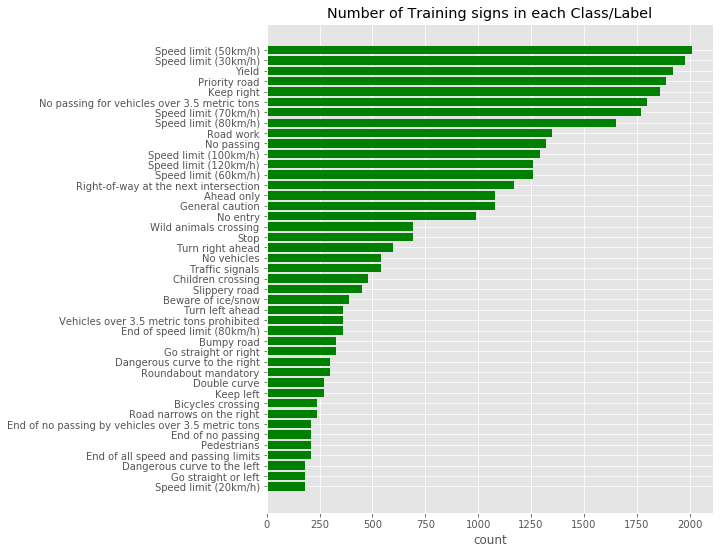

In [3]:
class_file_df = pd.read_csv("./signnames.csv", delimiter=',')

# How many unique classes/labels there are in the dataset.
n_classes = class_file_df.shape[0]

# Lets see how many of each type I have in my training data
plt.style.use('ggplot')
# get the counts of signs in the training dataset
unique, counts = np.unique(y_train, return_counts=True)
# since the signs are sorted 1-42 we can just add the count to the dataframe
class_file_df['train_count'] = pd.Series(counts,index=class_file_df.index)
# And sort the dataframe by the counts of the signs to make the plot look nice
class_file_df = class_file_df.sort_values(by=['train_count'])

# setup the plot and show it
fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111)
signs = class_file_df['SignName']
y_pos = np.arange(len(signs))
count = class_file_df['train_count']

ax.barh(y_pos, count, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(signs)
ax.set_xlabel('count')
ax.set_title('Number of Training signs in each Class/Label')
plt.savefig(writeup_dir+"class_count")
plt.show()

Let's take a look at what each sign looks like

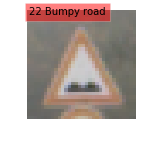

In [5]:
# The first image of each sign is quite dark... so lets shuffle it up to help get better looking images
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
index = random.randint(0, len(X_train))
plt.figure(figsize=(2,2))
plt.text(0.1, 0.9,"%s %s" % (y_train[index],class_file_df['SignName'][y_train[index]]), bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.imshow(X_train[index])
if False:
    import collections
    lookedat={}
    for i in range(len(y_train)):
        if y_train[i] in lookedat:
            continue
        else:
            image = X_train[i].squeeze()
            lookedat[y_train[i]] = image
    od = collections.OrderedDict(sorted(lookedat.items()))
    for key, image in od.items():        
        plt.figure(figsize=(2,2))
        plt.text(0.1, 0.9,"%s %s" % (key,class_file_df['SignName'][key]), bbox=dict(facecolor='red', alpha=0.5))
        plt.axis('off')
        plt.imshow(image)
        plt.savefig(writeup_dir+"%s training sample" % (key))

## Preprocess Data

Shuffle the training data.


In [6]:
# they've already been shuffled, but another time wont hurt
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

Some helper functions to pre-process the data

In [7]:
def images_to_gray(images):
    output = []
    for image in images:
        output.append(image_to_gray(image))
    return output;

def image_to_gray(img):
    """Applies the YUV transform"""
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

def normalize(image):
    """Normalizes images"""
    channels = cv2.split(image)
    channel_len = len(channels)
    num_image_elements = 32*32*channel_len
    chan = []
    image_chan_mean, image_chan_stddev = cv2.meanStdDev(image)
    for i in range(channel_len):
        chan.append(abs((channels[i]- image_chan_mean[i])/max(image_chan_stddev[i], 1./math.sqrt(num_image_elements))))
    return cv2.merge(chan)

def normalize(image):
    """Normalizes images"""
    channels = cv2.split(image)
    channel_len = len(channels)
    num_image_elements = 32*32*channel_len
    chan = []
    image_chan_mean, image_chan_stddev = cv2.meanStdDev(image)
    for i in range(channel_len):
        chan.append((channels[i]- image_chan_mean[i])/max(image_chan_stddev[i], 1./math.sqrt(num_image_elements)))
    return cv2.merge(chan)

def normalize_batch(images):
    output = []
    for image in images:
        output.append(normalize(image))
    return output

def random_image_distortion(image):
    if random.randint(0,10) > 5:
        distorted_image = rotate_image_random_amount(image)
    if random.randint(0,10) > 5:
        distorted_image = flip(image)
    else:
        return image
    distorted_image = np.reshape(distorted_image, [32,32,channels])
    return distorted_image

def rotate_image_random_amount(image):
    #https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point#9042907
    angle = random.randint(-90,90)
    #rotation angle in degree
    return ndimage.rotate(image, angle)

def flip(image):
    horizontal_img = cv2.flip( image, 0 )
    return horizontal_img

def increase_brightness(img, value=50):
    #https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [8]:
def preprocess_img(image, choice="gray_normal"):
    """
    Returns the preprocessed image based on the choice variable
    """
    return {
#         'adaptive_th': cv2.adaptiveThreshold(image_to_gray(image),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#                 cv2.THRESH_BINARY,3,3),
        'grayscale': image_to_gray(image),
        'gray_normal': normalize(image_to_gray(image)),
        'normal': normalize(image),
        'gray_bright': image_to_gray(increase_brightness(image, 120)),
    }[choice]

def preprocess_imgs(images, choice="gray_normal"):
    """
    Preprocesses a list of images
    """
    output = []
    if choice == "normal":
        channels = 3
    else:
        channels = 1
    for image in images:
        output.append(preprocess_img(image, choice))
    output = [np.reshape(me, [32,32,channels]) for me in output]
    return output

Pre-process the data to be set to grayscale and normalized

In [9]:
channels = 1
X_train = preprocess_imgs(X_train, 'gray_normal')
X_validation = preprocess_imgs(X_validation ,'gray_normal')
X_test = preprocess_imgs(X_test, 'gray_normal')


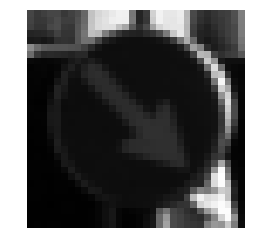

In [11]:
cpy = X_train[random.randint(0, len(X_train))]
cpy = np.reshape(cpy, [32,32])
plt.figure()
plt.axis("off")
plt.imshow(cpy, cmap="gray")
plt.savefig(writeup_dir+"normal_gray")

## Setup TensorFlow


In [12]:
import tensorflow as tf
tf.reset_default_graph()
EPOCHS = 50
BATCH_SIZE = 256

## The Model:
Taking a hint from the [Stanford CS231n homepage](http://cs231n.stanford.edu/) I used the following architecture
### Architecture
| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 grayscale image   					| 
| Convolution1 3x3     	| 1x1 stride, valid padding, outputs 30x30x6    |
| RELU					|												|
| Convolution2 3x3     	| 1x1 stride, valid padding, outputs 28x28x16   |
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 14x14x16 				|
| Convolution3 3x3     	| 1x1 stride, valid padding, outputs 12x12x32   |
| RELU					|												|
| Convolution4 3x3     	| 1x1 stride, valid padding, outputs 10x10x32   |
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 5x5x64 				    |
| Convolution5 3x3     	| 1x1 stride, valid padding, outputs 3x3x128    |
| RELU					|												|
| Convolution6 3x3     	| 1x1 stride, valid padding, outputs 2x2x140    |
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 1x1x140 				    |
| Fully connected		| input: 140 output: 120 					    |
| Fully connected		| input: 120 output: 84 						|
| Fully connected   	| input: 84 output: 43						    |

### Output
Return the result of the 3nd fully connected layer.

In [13]:
from tensorflow.contrib.layers import flatten
#conv, conv, pool x 3 then 2fcs
def CCPx3FCx2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    with tf.name_scope("conv1"):
        # Layer 1: Convolutional. Input = 32x32xchannels. Output = 30x30x6.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, channels, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # Activation.
        conv1 = tf.nn.relu(conv1)
        
        tf.summary.histogram("weights", conv1_W)
        tf.summary.histogram("biases", conv1_b)
        tf.summary.histogram("activations", conv1)
    
    with tf.name_scope("conv2"):
        # Layer 2: Convolutional. Output = 28x28x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # Activation.
        conv2 = tf.nn.relu(conv2)
        
        tf.summary.histogram("weights", conv2_W)
        tf.summary.histogram("biases", conv2_b)
        tf.summary.histogram("activations", conv2)

        # Pooling. Input = 28x28x16. Output = 14x14x32.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    with tf.name_scope("conv3"):
        # Layer 3: Convolutional. Output = 12x12x32.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
        conv3_b = tf.Variable(tf.zeros(32))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

        # Activation.
        conv3 = tf.nn.relu(conv3)
        
        tf.summary.histogram("weights", conv3_W)
        tf.summary.histogram("biases", conv3_b)
        tf.summary.histogram("activations", conv3)
        
    with tf.name_scope("conv4"):
        # Layer 4: Convolutional. Output = 10x10x32.
        conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
        conv4_b = tf.Variable(tf.zeros(64))
        conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b

        # Activation.
        conv4 = tf.nn.relu(conv4)
        
        tf.summary.histogram("weights", conv4_W)
        tf.summary.histogram("biases", conv4_b)
        tf.summary.histogram("activations", conv4)

        # Pooling. Input = 10x10x64. Output = 5x5x64.
        conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
 
    with tf.name_scope("conv5"):
        # Layer 5: Convolutional. Output = 3x3x128.
        conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
        conv5_b = tf.Variable(tf.zeros(128))
        conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b

        # Activation.
        conv5 = tf.nn.relu(conv5)
        
        tf.summary.histogram("weights", conv5_W)
        tf.summary.histogram("biases", conv5_b)
        tf.summary.histogram("activations", conv5)
        
    with tf.name_scope("conv6"):
        # Layer 6: Convolutional. Output = 2x2x140
        conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 140), mean = mu, stddev = sigma))
        conv6_b = tf.Variable(tf.zeros(140))
        conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b

        # Activation.
        conv6 = tf.nn.relu(conv6)
        
        tf.summary.histogram("weights", conv6_W)
        tf.summary.histogram("biases", conv6_b)
        tf.summary.histogram("activations", conv6)

        # Pooling. Input = 2x2x140. Output = 1x1x140.
        conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Flatten. Input = 1x1x140. Output = 140.
    fc0   = flatten(conv6)
   
    with tf.name_scope("fc1"):
        # Layer : Fully Connected. Input = 140. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(140, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # Activation.
        fc1    = tf.nn.relu(fc1)
        
        tf.summary.histogram("weights", fc1_W)
        tf.summary.histogram("biases", fc1_b)
        tf.summary.histogram("activations", fc1)

    with tf.name_scope("fc2"):
        # Layer : Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b

        # Activation.
        fc2    = tf.nn.relu(fc2)
        fc2    = tf.nn.dropout(fc2, 0.5)
        
        tf.summary.histogram("weights", fc2_W)
        tf.summary.histogram("biases", fc2_b)
        tf.summary.histogram("activations", fc2)

    with tf.name_scope("logits"):
        # Layer : Fully Connected. Input = 84. Output = 43.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        tf.summary.histogram("weights", fc3_W)
        tf.summary.histogram("biases", fc3_b)
        tf.summary.histogram("activations", logits)
    
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

<tf.Tensor 'input:0' shape=() dtype=string>

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [15]:
rate = 0.001

logits = CCPx3FCx2(x)
with tf.name_scope("cross-entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits, name="cross-entropy")
    loss_operation = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("cross-entropy", loss_operation)
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [16]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy_operation)
summ = tf.summary.merge_all()
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        [accuracy,s] = sess.run([accuracy_operation,summ], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        writer.add_summary(s, i)
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [17]:
LOGDIR = "./tensorboard_data/"
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + "with image distortions")
    writer.add_graph(sess.graph)
    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './model.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.724

EPOCH 2 ...
Validation Accuracy = 0.863

EPOCH 3 ...
Validation Accuracy = 0.898

EPOCH 4 ...
Validation Accuracy = 0.923

EPOCH 5 ...
Validation Accuracy = 0.936

EPOCH 6 ...
Validation Accuracy = 0.920

EPOCH 7 ...
Validation Accuracy = 0.933

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.939

EPOCH 10 ...
Validation Accuracy = 0.948

Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

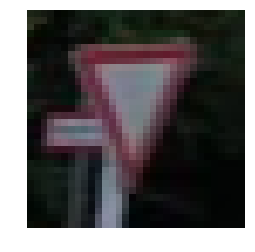

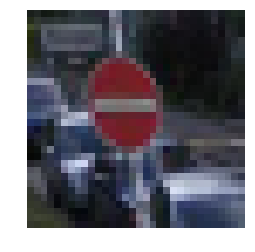

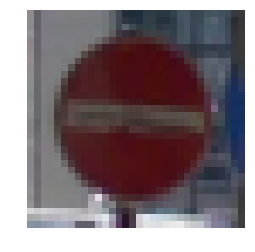

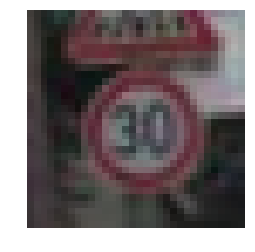

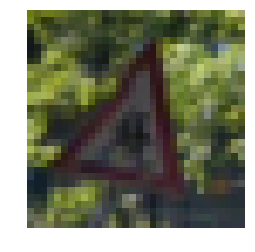

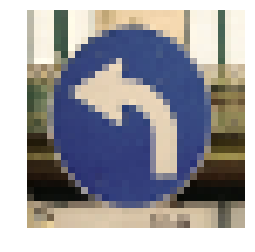

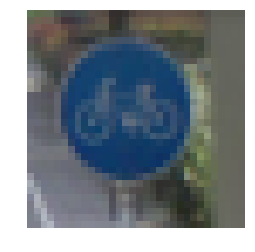

In [16]:
def get_img_paths(root_dir):
    test_imgs = os.listdir(root_dir)
    for i in range(len(test_imgs)):
        test_imgs[i] = "signs_from_google_maps/"+test_imgs[i]
    return test_imgs

def load_images(files):
    images = []
    for file in files:
        images.append(mpimg.imread(file))
    return images

def view_images(images):
    fig = plt.figure()
    for img in images:
        %matplotlib inline
        plt.imshow(img)
        plt.axis("off")
        plt.show()
image_from_google_maps = load_images(get_img_paths( "signs_from_google_maps"))
view_images(image_from_google_maps)

#### Pre-Process the test images

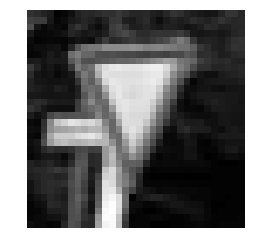

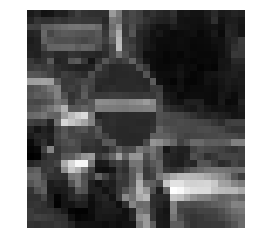

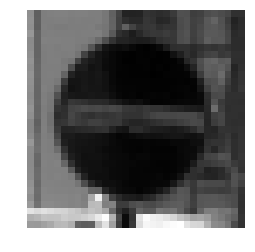

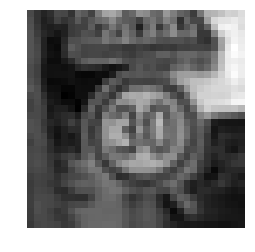

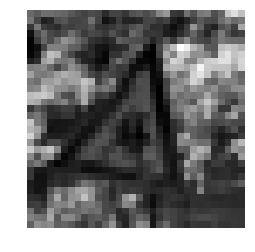

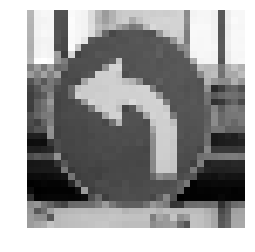

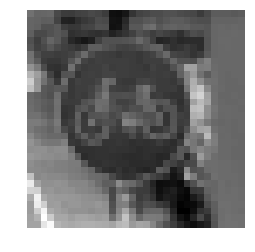

In [21]:
preprocessed_images = []
for i in range(len(image_from_google_maps)):
    preprocessed_images.append(cv2.merge(cv2.split(image_from_google_maps[0])[0:3]))
preprocessed_images = preprocess_imgs(image_from_google_maps)
for img in preprocessed_images:
    cpy = img
    cpy = np.reshape(cpy,[32,32])
    plt.figure()
    plt.axis("off")
    plt.imshow(cpy, cmap="gray")
    plt.show
# preprocessed_images

#### Load the model and run the new images

In [23]:
y_signs_from_the_net = [13, 17, 17, 1, 28, 34, 29]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    probs = tf.nn.softmax(logits)
    predictions = sess.run(tf.nn.top_k(probs, k=3), feed_dict={x: preprocessed_images})
    
    test_accuracy = evaluate(preprocessed_images,y_signs_from_the_net)
#     sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=3))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("predictions: ", predictions)

for _class in predictions[1]:
    print(class_file_df['SignName'][_class])



Test Accuracy = 0.571


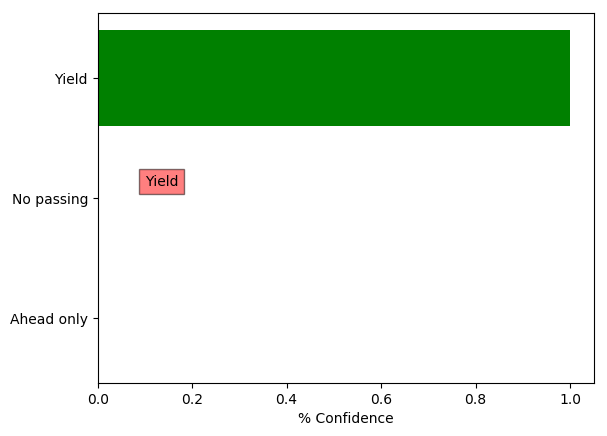

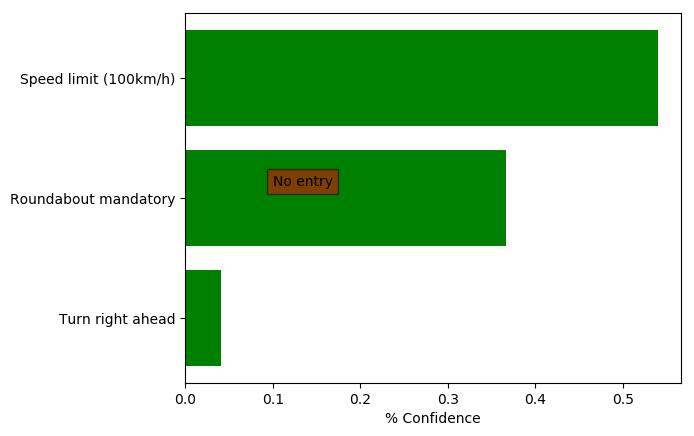

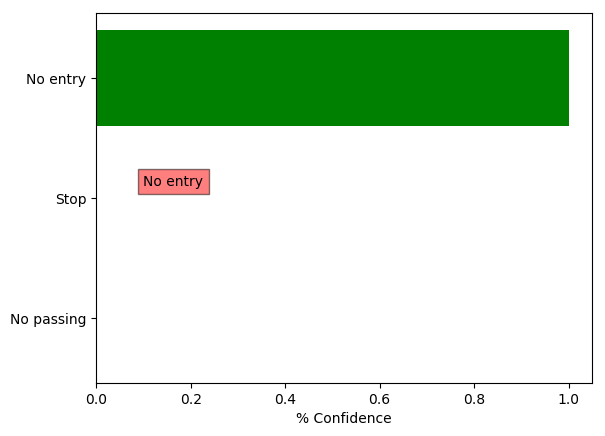

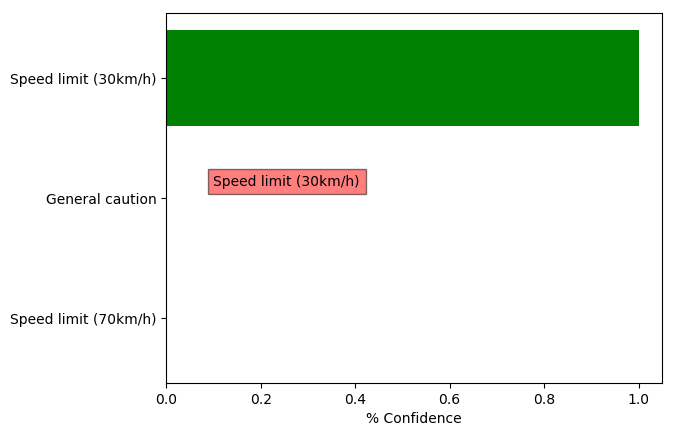

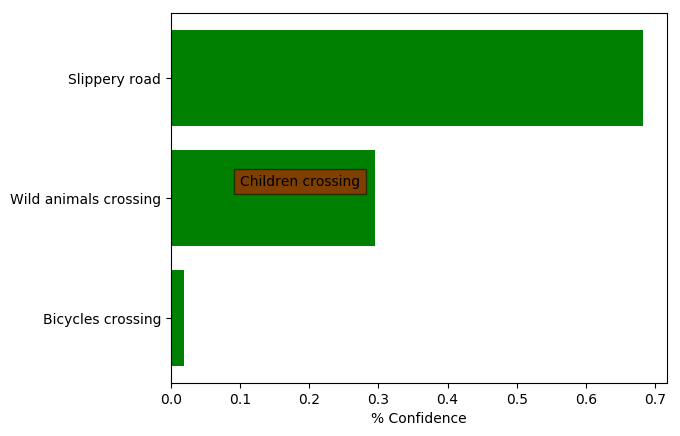

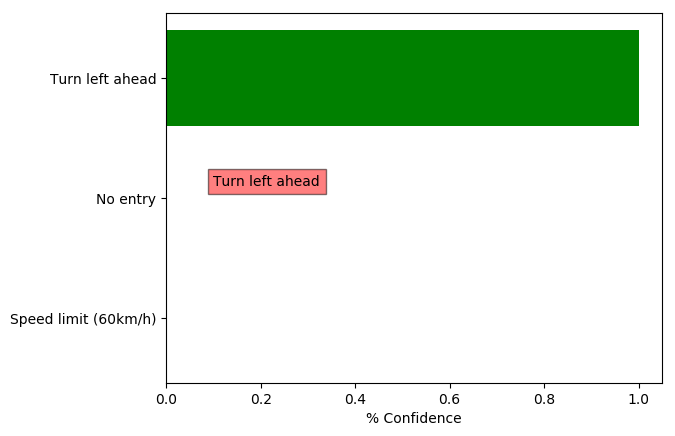

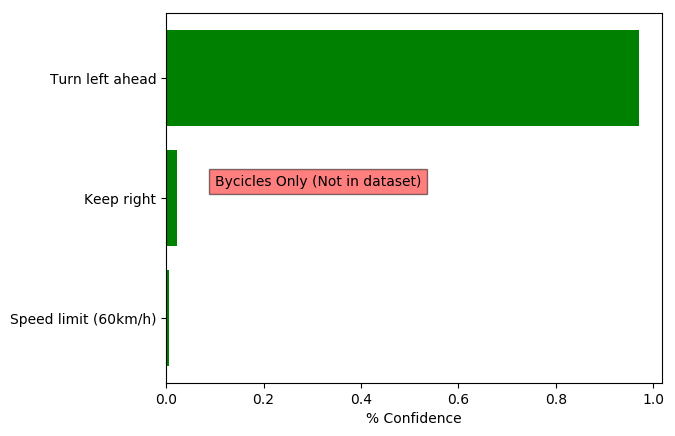

In [31]:
plt.rcdefaults()

                                        
for i in range(len(predictions[0])):
    fig, ax = plt.subplots()
    predict_class = [class_file_df['SignName'][predictions[1][i][0]], \
                     class_file_df['SignName'][predictions[1][i][1]], 
                     class_file_df['SignName'][predictions[1][i][2]]]
    y_pos = np.arange(len(predict_class))
    performance = [predictions[0][i][0], predictions[0][i][1], predictions[0][i][2]]

    ax.barh(y_pos, performance, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(predict_class)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('% Confidence')
    if i == len(predictions[0])-1:
        plt.text(0.1, 0.9,"Bycicles Only (Not in dataset)", bbox=dict(facecolor='red', alpha=0.5))
    else:
        plt.text(0.1, 0.9,"%s" % (class_file_df['SignName'][y_signs_from_the_net[i]]), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [19]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))

#     test_accuracy = evaluate(X_test, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))